## **HYPERPARAMETERS**

In [1]:
# training arguments:
# https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/trainer#transformers.TrainingArguments


base_model = 'bert-base-chinese'
batchsize = 12
prompt_len = n_tokens = 12
lr = 5e-4
epochs = 20
scheduler_type = "linear"
wd = 0.005
warmup_ratio = 0.1
myseed = 1126
nclass = 19
TESTSIZE = 0.2

## Loading dataset & Imports

In [2]:
#!pip -q install transformers
#!pip -q install datasets

In [3]:
# Server Paths 
# ..data/avo727/PromptTuning/CWNdata/Sean_PT2_encoded_dataset
maindir = "/mnt/md0/data/avo727/PromptTuning"
datadir = f"{maindir}/CWN_data"
preddir = f"{maindir}/model_predictions"
datasetdir= f"{maindir}/CWNdata/PT2_allchoice_encoded_dataset"

In [4]:
import pickle
from datasets import Dataset, load_metric
import datasets
from transformers import AutoModelForMultipleChoice, BertTokenizerFast
import random
import torch
import numpy as np
encoded_dataset = datasets.load_from_disk(datasetdir)

In [5]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['type_class', 'eng word', 'word', 'pos', 'instance', 'src', 'dot_type_2', 'dot_type_1', 'label', 'zh_type_class', 'zh_dot_type', 'zh_dot_type_2', 'zh_dot_gloss', 'is_one_ans', 'numchoices', 'class_selector', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 490
    })
    test: Dataset({
        features: ['type_class', 'eng word', 'word', 'pos', 'instance', 'src', 'dot_type_2', 'dot_type_1', 'label', 'zh_type_class', 'zh_dot_type', 'zh_dot_type_2', 'zh_dot_gloss', 'is_one_ans', 'numchoices', 'class_selector', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 123
    })
})

## Data collator 

In [6]:
tokenizer = BertTokenizerFast.from_pretrained(base_model)

In [7]:
from dataclasses import dataclass
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    allchoice version: 全數攤平送往model內部處理（不經unflatten，確保傳輸numchoices）
    """
    tokenizer = tokenizer
    padding, trunc = True, True
    max_length =  None
    pad_to_multiple_of = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        pin_label = True if "label" in features[0].keys() else False
        accepted_keys = ["input_ids", "attention_mask", "label", 
                         "token_type_ids", 'class_selector', 'numchoices']
        batch_size = len(features)
        labels = [feature.pop(label_name) for feature in features]
        numchoices = [feature.pop('numchoices') for feature in features]
        seq_classes = [feature.pop('class_selector') for feature in features]
        
        flattened_features = [[{k: v[i] for k, v in feature.items() if k in accepted_keys} 
                               for i in range(nc)] for feature, nc in zip(features, numchoices)]
        flattened_features = sum(flattened_features, [])
        batch = self.tokenizer.pad(
            flattened_features,
            padding= "longest",
            max_length= self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # flattened 
        batch = {k: v for k, v in batch.items() if k in accepted_keys}
        # print(len(batch['input_ids'])) # print(sum([len(x) for x in seq_classes])) # should match 
        batch["class_selector"] = torch.tensor(sum(seq_classes, [])) # flattening list of lists
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        batch["numchoices"] = torch.tensor(numchoices, dtype=torch.int64)

        return batch

In [8]:
RANGE = len(encoded_dataset['train'])
features = [{k: v for k, v in encoded_dataset["train"][i].items()} for i in range(RANGE)]
batch = DataCollatorForMultipleChoice()(features)
[(k, v.shape) for k, v in batch.items()]

[('input_ids', torch.Size([1014, 93])),
 ('token_type_ids', torch.Size([1014, 93])),
 ('attention_mask', torch.Size([1014, 93])),
 ('class_selector', torch.Size([1014])),
 ('labels', torch.Size([490])),
 ('numchoices', torch.Size([490]))]

## model

In [9]:
import torch
import torch.nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from transformers import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import MultipleChoiceModelOutput

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## logging

In [11]:
# !pip install wandb
# import wandb
# # wandb.login() # 87f450abf77ebb78b46b7cf9516b1bad9d6ef540

In [12]:
from datetime import datetime
now = datetime.now()
timeprefix = now.strftime("%m%d-%H%M")
runname = f'{timeprefix}_RPBert'
print('Name of the run:', runname)
# wandb.init(project="prompt_tuning_rp_v2", 
#            name = runname,
#            tags=["prompt-tuning", "regular-polysemy"],
#            group="bert")
# wandb.config.update({'n_tokens':n_tokens})

# # https://docs.wandb.ai/guides/integrations/huggingface

Name of the run: 0316-1919_RPBert


## freezed bert

In [19]:
from PromptTuningBERT_allchoice import BertPromptForMultipleChoice
config = {
    'n_tokens': prompt_len ,
    'n_class': nclass,
    'train_bert': False,
    'to_debug': False,
    'device': 'cuda'
} # model forwarding creates new tensors out of the original inputs, so device shall be specified beforehand
model = BertPromptForMultipleChoice.from_pretrained(base_model, config)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertPromptForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertPromptForMultipleChoice were not initialized from the model checkpoint at bert-ba

** total param is 175873
** train bert? False


In [20]:
model.to('cuda')

BertPromptForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

## Manual training loop 

In [22]:
import torch.nn
import torch.optim as optim
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loader = DataLoader(encoded_dataset['train'], 
                    shuffle=False, 
                    collate_fn=DataCollatorForMultipleChoice(), 
                    batch_size=batchsize)
loss_vec = []
for i in range(10):# epochs = 20 
    for batch in loader:  
        batch = {k: batch[k].to('cuda') for k in batch}
        optimizer.zero_grad()
        out = model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.item())
    print(loss_vec[-1])
        #writer.add_scalar("Loss/train", loss.item(), step_i)      
        #step_i += 1
# print(loss_vec)
# prompts: torch.Size([25, 12, 768]) # totalsentnumber, prompt_len, hidden_dim
# totalsentnumber: sum(numchoice for numchoice in this batch)

1.7176768779754639
1.6829617023468018
1.292707920074463
0.8405603170394897
0.3639366626739502
0.28752052783966064
0.09441858530044556
0.1253374069929123
0.05292954668402672
0.021745776757597923


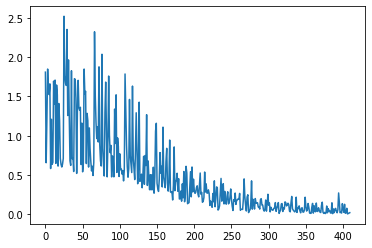

In [23]:
from matplotlib import pyplot as plt
plt.plot(loss_vec)

In [25]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    runname, 
    learning_rate=lr,
    per_device_train_batch_size=batchsize,
    per_device_eval_batch_size=batchsize,
    num_train_epochs=epochs,
    gradient_accumulation_steps=1, 
    weight_decay=wd,
    warmup_ratio = warmup_ratio,
    lr_scheduler_type=scheduler_type,
    logging_strategy="epoch",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    # report_to="wandb",
    load_best_model_at_end = False, # True: use eval loss
    seed = myseed # seeding!!!
)

In [26]:
def compute_metrics(logits_dict):
    # re_logits_mapping[nc] = reshaped_logits
    # 把三個的挑出來做成一組predictions matrix 
    # 兩個的挑出來做另一組 matrix
    print(typeof(logits_dict))
    print(logits_dict)
    # predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return #{'accuracy': (preds == label_ids).astype(np.float32).mean().item()}

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(),
    compute_metrics=compute_metrics,
)

In [28]:
# bert freeze version 
trainer.train()
# solution 1. 不要用trainer，寫manual training loop 
# pros: simplicity, controllable cons: hyperparams and scheduler feature will need to be added by ourselves
# solution 2. 改trainer.py裡的程式碼，修正prediction_step()
# https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py#L2445
# pros: keeping the hyperparams api simplicity cons: 可能還有一堆dependencies要修 

The following columns in the training set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: dot_type_1, zh_dot_type_2, zh_type_class, dot_type_2, pos, word, type_class, eng word, zh_dot_type, instance, zh_dot_gloss, is_one_ans, src.
/home/avo727/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 490
  Num Epochs = 20
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 820
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you c

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: dot_type_1, zh_dot_type_2, zh_type_class, dot_type_2, pos, word, type_class, eng word, zh_dot_type, instance, zh_dot_gloss, is_one_ans, src.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 12


AttributeError: 'dict' object has no attribute 'detach'

## Inference

In [ ]:
print("Evaluating...")
import numpy as np
# timeprefix = 0312-1300
best_ckpt = 'checkpoint-1064'
best_ckpt_path = f'{runname}/{best_ckpt}'
model = BertPromptForMultipleChoice.from_pretrained(best_ckpt_path, config)

trainer = Trainer(
    model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(),
    compute_metrics=compute_metrics,)

PredOutput = trainer.predict(
    test_dataset = encoded_dataset["test"])
    
labels = PredOutput.label_ids
print('acc:', compute_metrics((PredOutput.predictions, labels)))


logits_path = f"{preddir}/{timeprefix}_{best_ckpt}_logits"
preds_path = f"{preddir}/{timeprefix}_{best_ckpt}_predictions"
labels_path = f"{preddir}/{timeprefix}_{best_ckpt}_labels" # save because the dataset is shuffled
preds = np.argmax(PredOutput.predictions, axis=-1)

np.save(logits_path, PredOutput.predictions)
np.save(preds_path, preds)
np.save(labels_path,labels)

In [ ]:
wandb.finish()